In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# First lets import the clean data file

df = pd.read_csv('df.csv')
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Satisfaction Score,Card Type,Point Earned
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,2,DIAMOND,464
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,3,DIAMOND,456
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,3,DIAMOND,377
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,5,GOLD,350
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,5,GOLD,425


In [5]:
df.shape

(10000, 14)

Our task is a classification problem aimed at predicting whether a customer will exit or not.
The plan involves the following steps:

- Scaling numerical variables
- Balancing the target variable to address any class imbalance.
- Processing categorical variables, specifically by creating the necessary dummy variables.

- Eliminating redundant columns, such as those resulting from dummy variable creation, and any other columns deemed unnecessary for the model.

## 1.- Scaling numerical features, not target variable

In [5]:
# lets import the standardscaler()
from sklearn.preprocessing import StandardScaler,OneHotEncoder

In [6]:
# lets split our data in Features and target
X = df.drop(['Exited'], axis= 1)
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Satisfaction Score,Card Type,Point Earned
0,619,France,Female,42,2,0.00,1,1,1,101348.88,2,DIAMOND,464
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,3,DIAMOND,456
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,3,DIAMOND,377
3,699,France,Female,39,1,0.00,2,0,0,93826.63,5,GOLD,350
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,5,GOLD,425


In [7]:
y = df['Exited']
y

0       1
1       0
2       1
3       0
4       0
       ..
9995    0
9996    0
9997    1
9998    1
9999    0
Name: Exited, Length: 10000, dtype: int64

In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CreditScore         10000 non-null  int64  
 1   Geography           10000 non-null  object 
 2   Gender              10000 non-null  object 
 3   Age                 10000 non-null  int64  
 4   Tenure              10000 non-null  int64  
 5   Balance             10000 non-null  float64
 6   NumOfProducts       10000 non-null  int64  
 7   HasCrCard           10000 non-null  int64  
 8   IsActiveMember      10000 non-null  int64  
 9   EstimatedSalary     10000 non-null  float64
 10  Satisfaction Score  10000 non-null  int64  
 11  Card Type           10000 non-null  object 
 12  Point Earned        10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1015.8+ KB


In [9]:
# Lets use the custom scaler, this also could be save in a different notebook saved as py and called as class in this notebook
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

class CustomScaler(BaseEstimator,TransformerMixin):
    def __init__(self,columns,copy=True,with_mean=True,with_std=True):
        self.scaler = StandardScaler(copy=copy,with_mean=with_mean,with_std=with_std)
        self.columns = columns
        self.with_mean = with_mean
        self.with_std = with_std
        self.copy = copy
        self.mean_ = None
        self.std_ = None

    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns],y)
        self.mean_ = np.mean(X[self.columns])
        self.std_ = np.std(X[self.columns])
        return self

    def transform(self, X, y=None, copy=None):
        init_col_order = X.columns
        X_scaled = pd.DataFrame(self.scaler.transform(X[self.columns]), columns= self.columns)
        X_notscaled = X.loc[:,~X.columns.isin(self.columns)]
        return pd.concat([X_notscaled,X_scaled], axis = 1)[init_col_order]

In [10]:
# now lets standarized the numerical variables, two ways we could do it manually selecting which columns will be standarized or
# we create a list of columns by DataFrame.select_dtypes([include = 'float64','int64'])
# numerical_cols = X.select_dtypes( include = ['float64','int64']).columns
# numerical_cols
X.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Satisfaction Score', 'Card Type', 'Point Earned'],
      dtype='object')

In [11]:
# there is a note to consider variables 'HasCrCard' and 'IsActiveMember' are binary only 0 for no and 1 for yes
# so those features are not going to be standardized
numerical_cols = df[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts','EstimatedSalary', 'Satisfaction Score',
       'Point Earned']].columns

In [12]:
numerical_cols

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'EstimatedSalary', 'Satisfaction Score', 'Point Earned'],
      dtype='object')

In [13]:
# lets create an instantiation of the CustomScaler() class
churn_scaler = CustomScaler(columns= numerical_cols,copy=True,with_mean=True,with_std=True)

In [14]:
churn_scaler.fit(X)

C:\Users\Alfredo\Anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


CustomScaler(columns=Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'EstimatedSalary', 'Satisfaction Score', 'Point Earned'],
      dtype='object'))

In [15]:
X = churn_scaler.transform(X)

In [16]:
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Satisfaction Score,Card Type,Point Earned
0,-0.326221,France,Female,0.293517,-1.041760,-1.225848,-0.911583,1,1,0.021886,-0.721130,DIAMOND,-0.630839
1,-0.440036,Spain,Female,0.198164,-1.387538,0.117350,-0.911583,0,1,0.216534,-0.009816,DIAMOND,-0.666251
2,-1.536794,France,Female,0.293517,1.032908,1.333053,2.527057,1,0,0.240687,-0.009816,DIAMOND,-1.015942
3,0.501521,France,Female,0.007457,-1.387538,-1.225848,0.807737,0,0,-0.108918,1.412812,GOLD,-1.135457
4,2.063884,Spain,Female,0.388871,-1.041760,0.785728,-0.911583,1,1,-0.365276,1.412812,GOLD,-0.803472


In [17]:
import joblib
import pickle

In [18]:
with open('Scaler_file.pkl','wb') as file:
    pickle.dump(churn_scaler, file)

In [19]:
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Satisfaction Score,Card Type,Point Earned
0,-0.326221,France,Female,0.293517,-1.041760,-1.225848,-0.911583,1,1,0.021886,-0.721130,DIAMOND,-0.630839
1,-0.440036,Spain,Female,0.198164,-1.387538,0.117350,-0.911583,0,1,0.216534,-0.009816,DIAMOND,-0.666251
2,-1.536794,France,Female,0.293517,1.032908,1.333053,2.527057,1,0,0.240687,-0.009816,DIAMOND,-1.015942
3,0.501521,France,Female,0.007457,-1.387538,-1.225848,0.807737,0,0,-0.108918,1.412812,GOLD,-1.135457
4,2.063884,Spain,Female,0.388871,-1.041760,0.785728,-0.911583,1,1,-0.365276,1.412812,GOLD,-0.803472


In [20]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Satisfaction Score,Card Type,Point Earned
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,2,DIAMOND,464
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,3,DIAMOND,456
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,3,DIAMOND,377
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,5,GOLD,350
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,5,GOLD,425


### 2. Creating dummy variables from the Categorical Variables

In [22]:
#lets work with the categorical variables
categorical_cols = X.select_dtypes(include=['object']).columns
categorical_cols         # notice that categorical_cols is just an array with the names of the categorical columns

Index(['Geography', 'Gender', 'Card Type'], dtype='object')

In [23]:
X[categorical_cols].head()

,Geography,Gender,Card Type
0,France,Female,DIAMOND
1,Spain,Female,DIAMOND
2,France,Female,DIAMOND
3,France,Female,GOLD
4,Spain,Female,GOLD


In [24]:
categorical_cols[0]


'Geography'

In [25]:
# lets create the dummy variables for each of the three categorical features
# first lets review the unique classes of each features / categorical_cols is a list-like object
for i in categorical_cols:
    print(df[i].unique())
  

['France' 'Spain' 'Germany']
['Female' 'Male']
['DIAMOND' 'GOLD' 'SILVER' 'PLATINUM']


In [26]:
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Satisfaction Score,Card Type,Point Earned
0,-0.326221,France,Female,0.293517,-1.041760,-1.225848,-0.911583,1,1,0.021886,-0.721130,DIAMOND,-0.630839
1,-0.440036,Spain,Female,0.198164,-1.387538,0.117350,-0.911583,0,1,0.216534,-0.009816,DIAMOND,-0.666251
2,-1.536794,France,Female,0.293517,1.032908,1.333053,2.527057,1,0,0.240687,-0.009816,DIAMOND,-1.015942
3,0.501521,France,Female,0.007457,-1.387538,-1.225848,0.807737,0,0,-0.108918,1.412812,GOLD,-1.135457
4,2.063884,Spain,Female,0.388871,-1.041760,0.785728,-0.911583,1,1,-0.365276,1.412812,GOLD,-0.803472


In [27]:
# creating an instantiation of this class OneHotEncoder with the parameter/argument drop= True to avoid the multicollinearity problem
# there is another method using Pandas: data_dummies = pd.get_dummies(data = data, columns=['Geography','Gender'],drop_first=True)

data_dummies = pd.get_dummies(data=X, columns= categorical_cols,drop_first=True,dtype='int')
data_dummies

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Satisfaction Score,Point Earned,Geography_Germany,Geography_Spain,Gender_Male,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER
0,-0.326221,0.293517,-1.041760,-1.225848,-0.911583,1,1,0.021886,-0.721130,-0.630839,0,0,0,0,0,0
1,-0.440036,0.198164,-1.387538,0.117350,-0.911583,0,1,0.216534,-0.009816,-0.666251,0,1,0,0,0,0
2,-1.536794,0.293517,1.032908,1.333053,2.527057,1,0,0.240687,-0.009816,-1.015942,0,0,0,0,0,0
3,0.501521,0.007457,-1.387538,-1.225848,0.807737,0,0,-0.108918,1.412812,-1.135457,0,0,0,1,0,0
4,2.063884,0.388871,-1.041760,0.785728,-0.911583,1,1,-0.365276,1.412812,-0.803472,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.246488,0.007457,-0.004426,-1.225848,0.807737,1,0,-0.066419,-1.432445,-1.356781,0,0,1,0,0,0
9996,-1.391939,-0.373958,1.724464,-0.306379,-0.911583,1,1,0.027988,1.412812,0.728088,0,0,1,0,1,0
9997,0.604988,-0.278604,0.687130,-1.225848,-0.911583,0,1,-1.008643,-0.009816,-0.188192,0,0,0,0,0,1
9998,1.256835,0.293517,-0.695982,-0.022608,0.807737,1,0,-0.125231,-0.721130,-1.184148,1,0,1,1,0,0


In [28]:
data_dummies.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Satisfaction Score,Point Earned,Geography_Germany,Geography_Spain,Gender_Male,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER
0,-0.326221,0.293517,-1.041760,-1.225848,-0.911583,1,1,0.021886,-0.721130,-0.630839,0,0,0,0,0,0
1,-0.440036,0.198164,-1.387538,0.117350,-0.911583,0,1,0.216534,-0.009816,-0.666251,0,1,0,0,0,0
2,-1.536794,0.293517,1.032908,1.333053,2.527057,1,0,0.240687,-0.009816,-1.015942,0,0,0,0,0,0
3,0.501521,0.007457,-1.387538,-1.225848,0.807737,0,0,-0.108918,1.412812,-1.135457,0,0,0,1,0,0
4,2.063884,0.388871,-1.041760,0.785728,-0.911583,1,1,-0.365276,1.412812,-0.803472,0,1,0,1,0,0


In [29]:
#checkpoint
data = pd.concat([data_dummies,df['Exited']],axis=1)

In [30]:
data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Satisfaction Score,Point Earned,Geography_Germany,Geography_Spain,Gender_Male,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER,Exited
0,-0.326221,0.293517,-1.041760,-1.225848,-0.911583,1,1,0.021886,-0.721130,-0.630839,0,0,0,0,0,0,1
1,-0.440036,0.198164,-1.387538,0.117350,-0.911583,0,1,0.216534,-0.009816,-0.666251,0,1,0,0,0,0,0
2,-1.536794,0.293517,1.032908,1.333053,2.527057,1,0,0.240687,-0.009816,-1.015942,0,0,0,0,0,0,1
3,0.501521,0.007457,-1.387538,-1.225848,0.807737,0,0,-0.108918,1.412812,-1.135457,0,0,0,1,0,0,0
4,2.063884,0.388871,-1.041760,0.785728,-0.911583,1,1,-0.365276,1.412812,-0.803472,0,1,0,1,0,0,0


In [31]:
data.shape

(10000, 17)

In [32]:

data.columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Satisfaction Score',
       'Point Earned', 'Geography_Germany', 'Geography_Spain', 'Gender_Male',
       'Card Type_GOLD', 'Card Type_PLATINUM', 'Card Type_SILVER', 'Exited'],
      dtype='object')

In [33]:
# lets order the data
data =data[['HasCrCard', 'IsActiveMember', 'CreditScore', 'Age', 'Tenure',
       'Balance', 'NumOfProducts', 'EstimatedSalary', 'Satisfaction Score',
       'Point Earned', 'Geography_Germany', 'Geography_Spain', 'Gender_Male',
       'Card Type_GOLD', 'Card Type_PLATINUM', 'Card Type_SILVER', 'Exited']]

In [34]:
data.head()

,HasCrCard,IsActiveMember,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Satisfaction Score,Point Earned,Geography_Germany,Geography_Spain,Gender_Male,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER,Exited
0,1,1,-0.326221,0.293517,-1.041760,-1.225848,-0.911583,0.021886,-0.721130,-0.630839,0,0,0,0,0,0,1
1,0,1,-0.440036,0.198164,-1.387538,0.117350,-0.911583,0.216534,-0.009816,-0.666251,0,1,0,0,0,0,0
2,1,0,-1.536794,0.293517,1.032908,1.333053,2.527057,0.240687,-0.009816,-1.015942,0,0,0,0,0,0,1
3,0,0,0.501521,0.007457,-1.387538,-1.225848,0.807737,-0.108918,1.412812,-1.135457,0,0,0,1,0,0,0
4,1,1,2.063884,0.388871,-1.041760,0.785728,-0.911583,-0.365276,1.412812,-0.803472,0,1,0,1,0,0,0


### 3 correcting invalance target variable

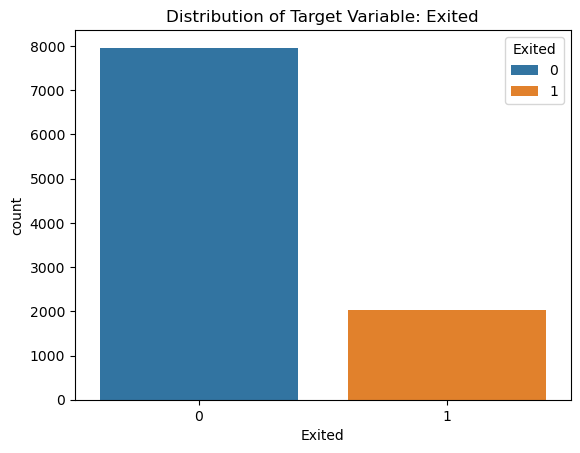

In [36]:
sns.countplot(data,x='Exited',hue='Exited')
plt.title('Distribution of Target Variable: Exited')
plt.show()

In [37]:
data['Exited'].value_counts()

Exited
0    7962
1    2038
Name: count, dtype: int64

In [38]:
X.shape

(10000, 13)

In [39]:
y = data['Exited']
y.shape

(10000,)

In [40]:
# importing the pertinent library 
from imblearn.over_sampling import SMOTE

In [41]:
# SMOTE will give us two numpy arrays, where the target value will be resampled after rebalance
X_resampled, y_resampled = SMOTE().fit_resample(X,y)

ValueError: could not convert string to float: 'France'

In [ ]:
y_resampled.value_counts()

In [ ]:
data_smoted = pd.concat([X_resampled,y_resampled],axis=1)
data_smoted

In [ ]:
data_smoted.to_csv('data_processed',index=False)